## **Challenge Two: Build a Data Product**  

# Data Preprocesing - 1

In [2]:
# Imports required
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing

In [3]:
# Configuring import properties
tqdm.pandas()
pd.set_option("display.max_rows", None, "display.max_columns", None)
nltk.download('stopwords')
nltk.download('punkt')
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Reading in the Merged CSV
df = pd.read_csv('merged_311.csv', index_col=[0])

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df.head()

,complaint_type,descriptor
0,HEATING,HEAT
1,HEATING,HEAT
2,PLUMBING,SHOWER-STALL
3,PAINT,WALLS
4,PAINT,CEILING


# Text Preprocessing

Text Preprocessing involves cleaning the training text data for the model. This is an important step of the pipeline as it helps improve prediction accuracy.

In [6]:
# Converting descriptor column to string type
df['descriptor'] = df['descriptor'].astype(str)

In [7]:
# Converting descriptor column values to lowercase
df['descriptor'] = df['descriptor'].str.lower()

In [8]:
# Checking the number of distinct complaint descriptions in the data
df['descriptor'].nunique()

1094

In [10]:
df['descriptor'].value_counts()[:20]

loud music/party                       1711604
heat                                    871935
entire building                         748780
street light out                        664412
no access                               645002
pothole                                 569254
banging/pounding                        486291
apartment only                          400948
ceiling                                 340127
request large bulky item collection     326335
loud talking                            287174
mold                                    244646
floor                                   230981
posted parking sign violation           226309
controller                              224723
partial access                          222918
pests                                   214857
with license plate                      207812
15 street cond/dump-out/drop-off        199513
14 derelict vehicles                    196553
Name: descriptor, dtype: int64

It is evident from the above result that there are thousands of redundant complaint descriptions. We can get rid of the duplicates to ease processing and improve prediction

In [11]:
# Length of df before removing duplicate complaint descriptions
len(df)

20747363

In [12]:
# Dropping rows which have duplicate complaint descriptions
df_no_duplicates = df.drop_duplicates(subset=['descriptor'], keep='first')

In [13]:
# Length of df after removing duplicate complaint descriptions
len(df_no_duplicates)

1094

As we can see, the length of the df has gone from 2074363 to 1094. That is a **99.94% decrease**.    

This particular step has already benefitted us in terms of:
*   avoiding redundant calculation
*   saving enormous compute time
*   improving model prediction probability

In [ ]:
# Checking that we still have each type of complaint description
df_no_duplicates['descriptor'].nunique()

1094

Before we get into text preprocessing, let us see why do we need to do it?

In [ ]:
df_no_duplicates['descriptor'].sample(n = 15)

5784                       street light dayburning
15790743                   disclosure not provided
41783                                   heavy flow
1524                no parking, standing, stopping
23451       air: smoke, other (use comments) (aa5)
37576                                 in post base
23499       housing education program course guide
47725                          other agency charge
16836                                trunk damaged
5748           working contrary to stop work order
1383570                         pool/billiard hall
513848             portable amusement ride license
90032                      animal boarding license
7063                 dismiss violation owner fixed
122495                           wood pole leaning
Name: descriptor, dtype: object

From the above samples of the complaint descriptions, it is evident there is a lot of **noise** in the data.  
The noise is anything which doesn't help us classify the complaint into one of the type. This includes **brackets**, **hyphens**, **numeric** characters, non-words, **special characters** etc.  
Removing this noise from the description text will drastically improve our model performance. Hence we need to do text preprocessing

The below defined text preprocessing function not only has the Traditional Natural Language Processing - Text Cleaning techniques, but also has **special methods** to clean the textual data in context with the NYC 311 dataset. I came up with these functions after obersving random samples of the data.

In [14]:
# Function to preprocess text

def preprocess_text(text):
    
    cleaned_text = text.replace("/", " ")
    
    cleaned_text = cleaned_text.replace(",", "")
    
    cleaned_text = cleaned_text.replace("-", " ")
    
    # Removes all characters present between brackets including the brackets
    cleaned_text = re.sub("[\(\[].*?[\)\]]", "", cleaned_text)
    
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)
    
    # tokenize the string
    tokens = word_tokenize(cleaned_text)

    # remove punctuation
    words = [word for word in tokens if word.isalpha()]

    # remove stop words
    words = [w for w in words if not w in stop_words]
    
    # join words to form a string
    cleaned_text = ' '.join(words)
    
    # remove extra spaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

In [15]:
# cloning the df_no_duplicates dataframe
df_cleaned = df_no_duplicates

# Applying text_preprocessing and storing results in the df_cleaned dataframe
df_cleaned['descriptor'] = df_no_duplicates['descriptor'].progress_apply(preprocess_text)

100%|██████████| 1094/1094 [00:00<00:00, 8207.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
# Removing rows which have empty complaint descriptions
df_cleaned = df_cleaned[df_cleaned.descriptor != '']

In [ ]:
# Removing NA values from df_cleaned
df_cleaned = df_cleaned.dropna(axis=0, how='any')

In [17]:
df_cleaned.head()

,complaint_type,descriptor
0,HEATING,heat
2,PLUMBING,shower stall
3,PAINT,walls
4,PAINT,ceiling
5,CONSTRUCTION,locks


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text major ticklabel objects>)

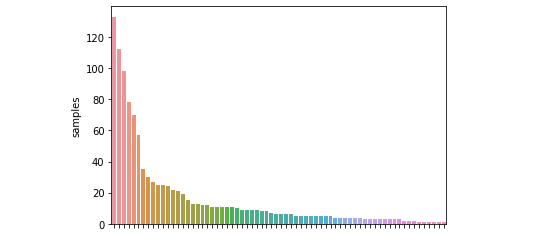

In [18]:
# Viewing distinct complaint type with counts
counts = df_cleaned['complaint_type'].value_counts()
sns.barplot(counts.index, counts)
plt.gca().set_ylabel('samples')
plt.xticks(color="white")

From above chart, we observe a huge class imbalance. But before we work on solving that problem, notice the labels with less than 10 samples  
The label with highest samples has a count of 133 samples.  
I am comprehending that even if we consider the labels with less than 10 samples, the model may never classify text into those classes, since the model will never learn much about these labels.  
So I have decided to drop the labels which have less than 10 samples.

In [23]:
# dropping samples which have less than 10 complaint descriptions
df_cleaned = df_cleaned[~df_cleaned['complaint_type'].isin(counts[counts < 10].index)]

# Label Encoding

In [24]:
# Using sklearn LabelEndoder to encode numeric labels for complaint_types which is our target variable
le = preprocessing.LabelEncoder()
le.fit(df_cleaned.complaint_type)
df_cleaned['labels'] = le.transform(df_cleaned.complaint_type)

In [27]:
df_cleaned.head()

,complaint_type,descriptor,labels
2,PLUMBING,shower stall,17
5,CONSTRUCTION,locks,1
6,PLUMBING,bathtub,17
7,PLUMBING,water leaks,17
14,OTHER,rubbish,16


This notebook creates the dataset with class imbalance.  
I have not applied augmentation to the data here.  
I will train models based on this data and further with the balanced data, to be able to compare the performance of both the datasets.  

In [ ]:
# saving the dataframe 
df.to_csv('nyc_311_imbalanced.csv')

In [ ]:
# saving the dataframe in format for AutoNLP HuggingFace Training

df_hf = df_cleaned.rename(columns={'complaint_type': 'target'})
del df_hf['labels']
df_hf.to_csv('hf_nyc_311_imbalanced.csv')